In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

# Computations

## A priori vs Steady state

In [3]:
Diffs = []
for temp in TEMPS:
    X = load_sequences(DATAPATH, temp)
    bouts_mc = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    Pb = MC.bout_proba(bouts_mc)
    Std = MC.steady_state(MC.bout_transitions(bouts_mc))
    Diffs.append(np.abs(Pb - Std))

In [4]:
f"Max diff between bout probability and steady state ; {np.array(Diffs).max():0.4f}"

'Max diff between bout probability and steady state ; 0.0028'

# Figure

## Example trajectory labeling

In [3]:
from matplotlib.markers import MarkerStyle

In [4]:
temp = 22
i = 382
angles, xpos, ypos = load_full_traj(DATAPATH, temp, i)
t = np.arange(len(angles))
bouts = MC.threshold_classifier([angles], -DTHETA_THRESH, +DTHETA_THRESH)[0]
bouts_hmm = load_viterbi(MODELPATH, "g3", temp)[i]

In [5]:
start, stop = 24, 75

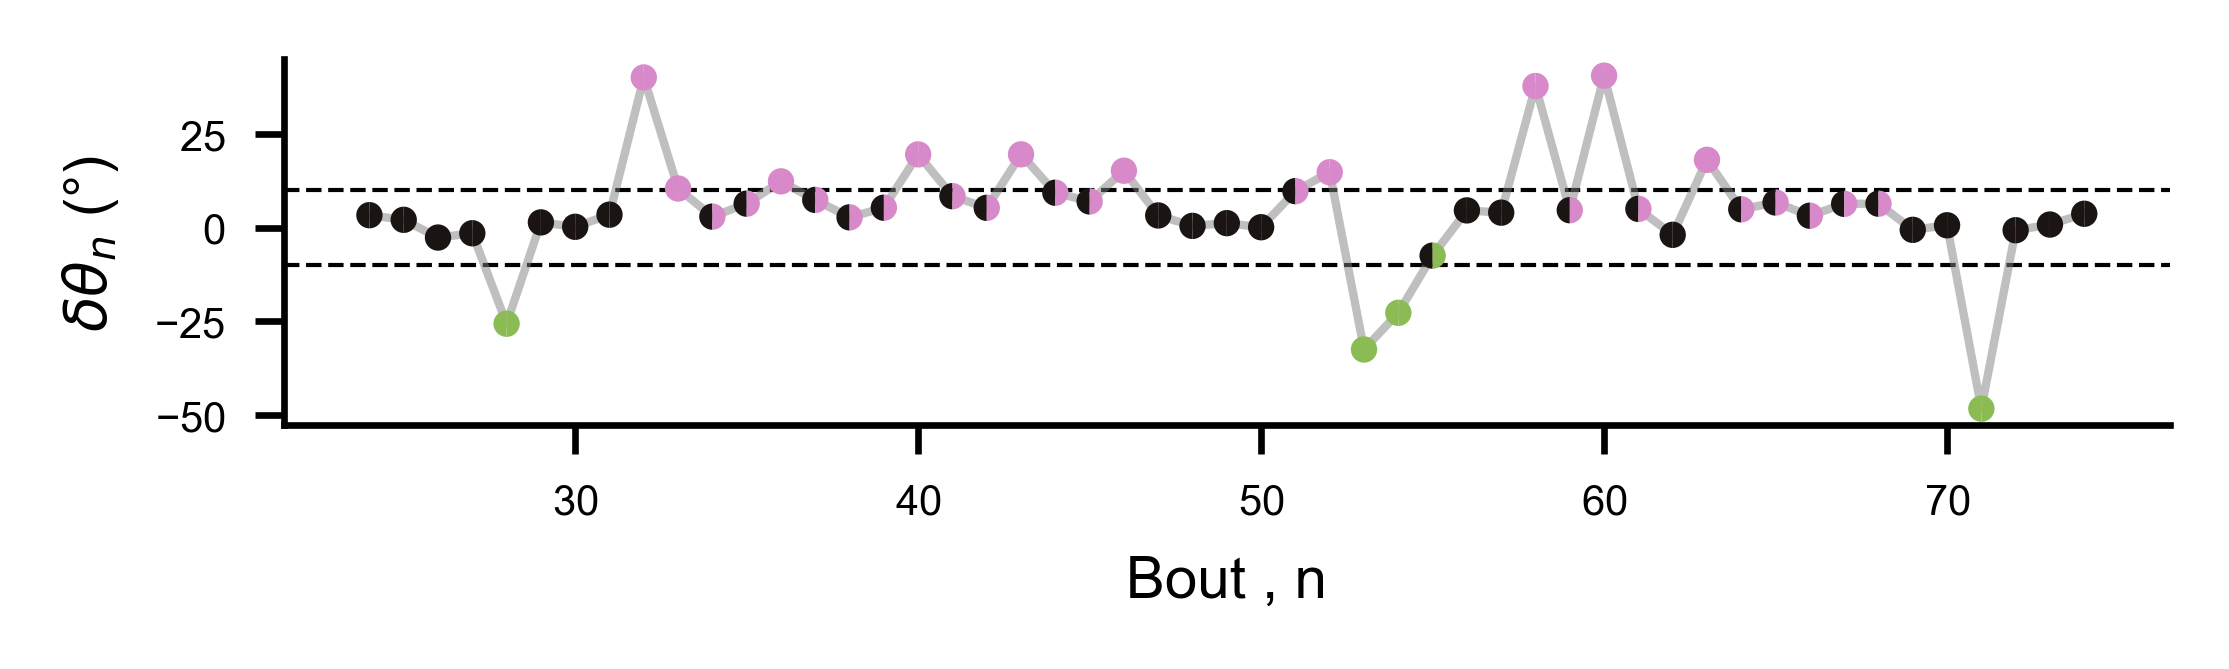

In [13]:
fig, ax = plt.subplots(figsize=(1.8*2,1))

ax.plot(
    t[start:stop], angles[start:stop], 
    zorder=1, 
    color="grey", linewidth=1, alpha=0.5
)
ax.scatter(
    t[start:stop], angles[start:stop], 
    c=FLR_colors[bouts[start:stop]], 
    s=10,
    zorder=2, marker=MarkerStyle("o", fillstyle="left"), linewidth=0
)
ax.scatter(
    t[start:stop], angles[start:stop], 
    c=FLR_colors[bouts_hmm[start:stop]], 
    s=10,
    zorder=3, marker=MarkerStyle("o", fillstyle="right"), linewidth=0
)
ax.axhline(+10, zorder=0, linewidth=0.5, linestyle="--")
ax.axhline(-10, zorder=0, linewidth=0.5, linestyle="--")
ax.set_xlabel("Bout , n")
ax.set_ylabel(r"$\delta\theta_n$ (°)")

fig.savefig(f"panels/Fig2/example_labeling_part1.svg")

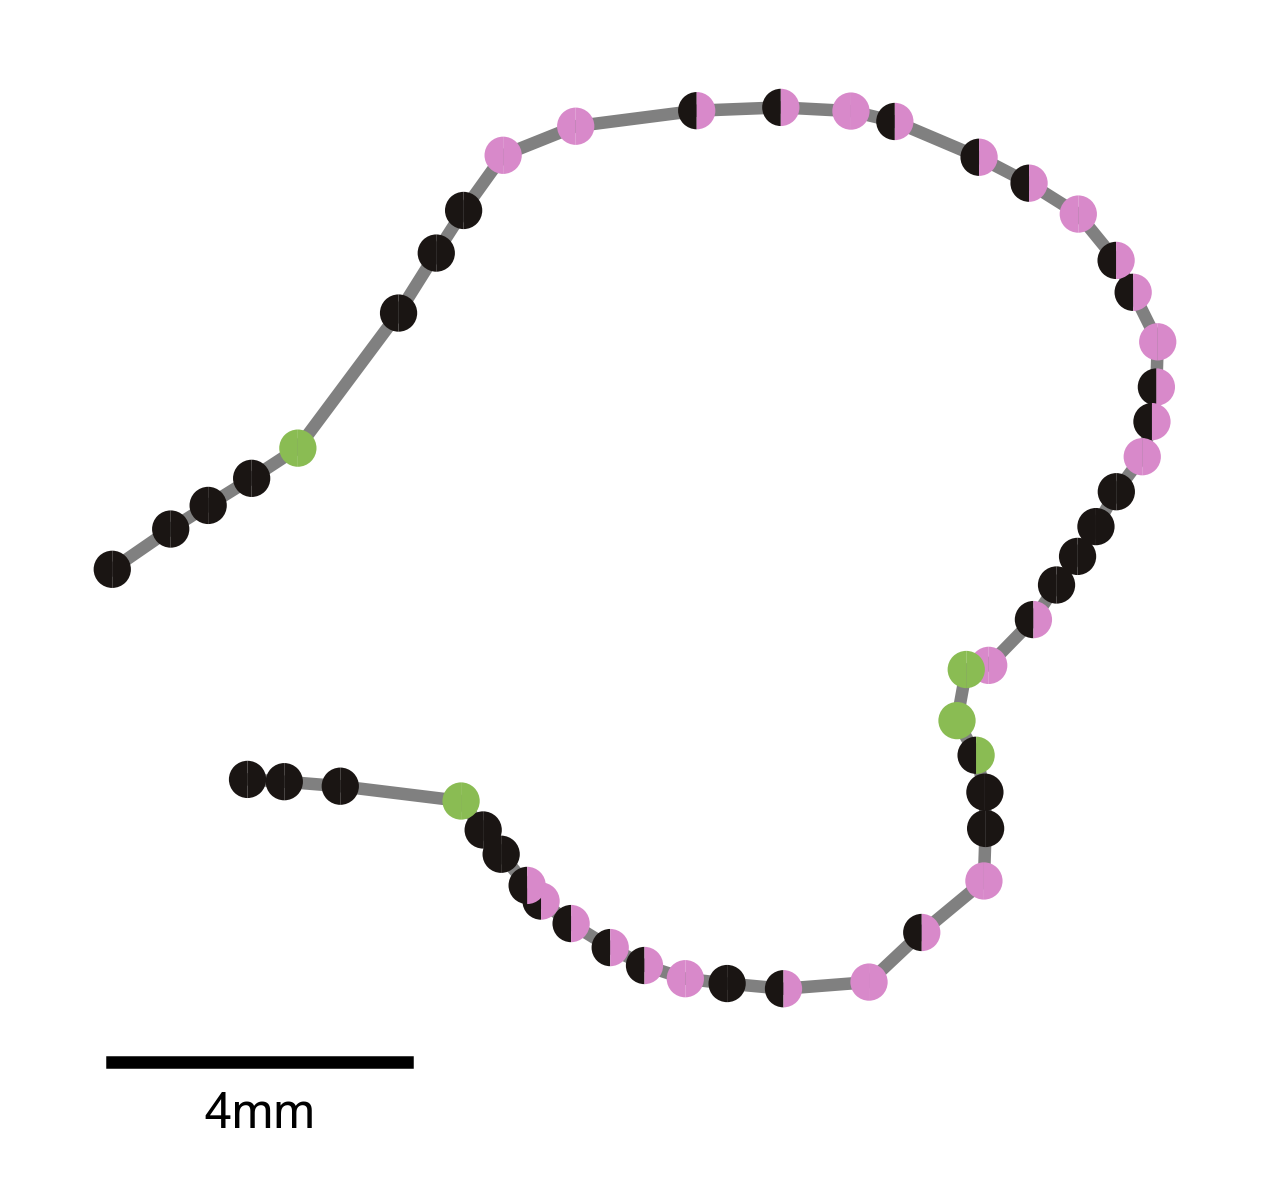

In [15]:
fig, ax = plt.subplots(figsize=(2,2))
ax.axis("off")
ax.set_aspect("equal")
X = xpos[start:stop]
Y = ypos[start:stop]
Cmc = FLR_colors[bouts[start:stop]]
Chmm = FLR_colors[bouts_hmm[start:stop]]

ax.plot(X,Y, zorder=0, color="grey")
ax.scatter(
    X, Y, c=Cmc, 
    zorder=1, marker=MarkerStyle("o", fillstyle="left"), 
    s=20, linewidth=0
)
ax.scatter(
    X, Y, c=Chmm, 
    zorder=1, marker=MarkerStyle("o", fillstyle="right"), 
    s=20, linewidth=0
)

ymin = Y.min() - 1
xmin = X.min()
ax.plot([xmin,xmin+4],[ymin,ymin])
ax.text(xmin+2,ymin-0.4,"4mm",ha="center", va="top")

fig.savefig(f"panels/Fig2/example_labeling_part2.svg")

## Panel : Confusion Matrix

In [5]:
from utils.misc import confusion, plot_confusion

In [6]:
temp  = 22
C = confusion(
        MC.threshold_classifier(load_sequences(DATAPATH, temp), -DTHETA_THRESH, +DTHETA_THRESH), 
        load_viterbi(MODELPATH, "g3", temp),
        3,
        3
    )

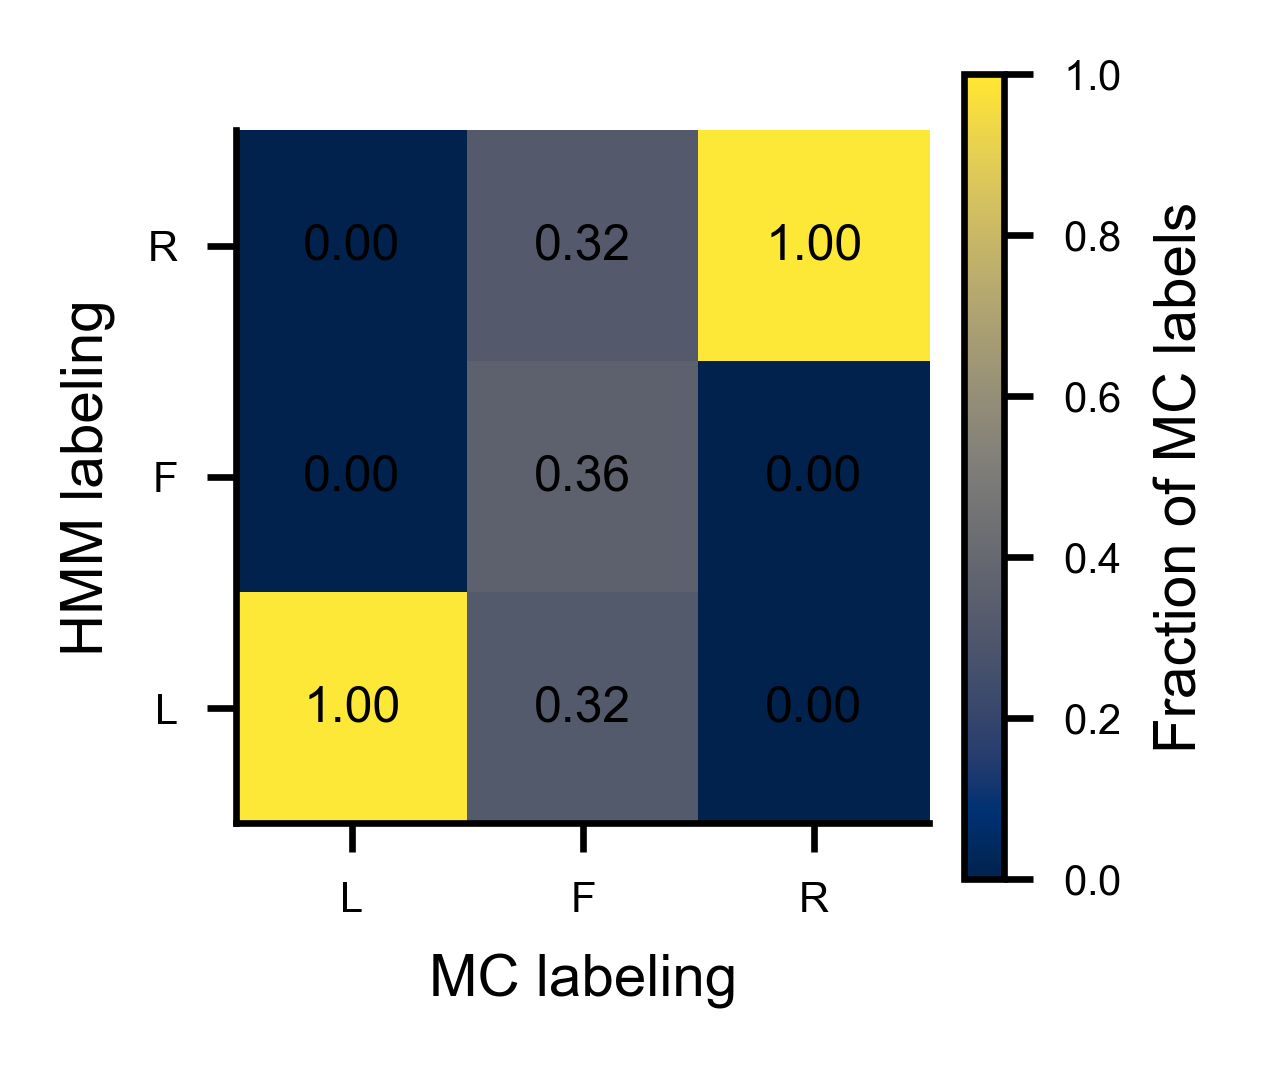

In [8]:
temp = 22
fig, ax = plt.subplots()
h = plot_confusion(ax, 
    C[[1,0,2],:][:,[1,0,2]],
    ["L","F","R"],
    ["L","F","R"],
)
fig.colorbar(h, ax=ax, label="Fraction of MC labels", shrink=0.70)
ax.set_xlabel("MC labeling")
ax.set_ylabel("HMM labeling")

fig.savefig("panels/Fig2/confusion.svg")

## Panel : Streaks

In [14]:
from utils.misc import find_streaks, streak_decay_const

In [15]:
lenghts = np.arange(1,20)

In [16]:
# at all temperatures
Decays = np.empty((len(TEMPS), 2, 2)) # ( temps x model x (F,T) )
for t,temp in enumerate(TEMPS):
    X = load_sequences(DATAPATH, temp)
    bouts_mc = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    bouts_hmm = load_viterbi(MODELPATH, "g3", temp)
    streak_lengths_hmm = find_streaks(bouts_hmm, [0,1,2], lenghts)
    streak_lengths_mc = find_streaks(bouts_mc, [0,1,2], lenghts)
    Decays[t,0,0], Decays[t,0,1], _, _ = streak_decay_const(streak_lengths_mc, lenghts)
    Decays[t,1,0], Decays[t,1,1], _, _ = streak_decay_const(streak_lengths_hmm, lenghts)

In [17]:
# at example temperature
temp = 22
X = load_sequences(DATAPATH, temp)
bouts_mc = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
bouts_hmm = load_viterbi(MODELPATH, "g3", temp)
streak_lengths_hmm = find_streaks(bouts_hmm, [0,1,2], lenghts)
streak_lengths_mc = find_streaks(bouts_mc, [0,1,2], lenghts)

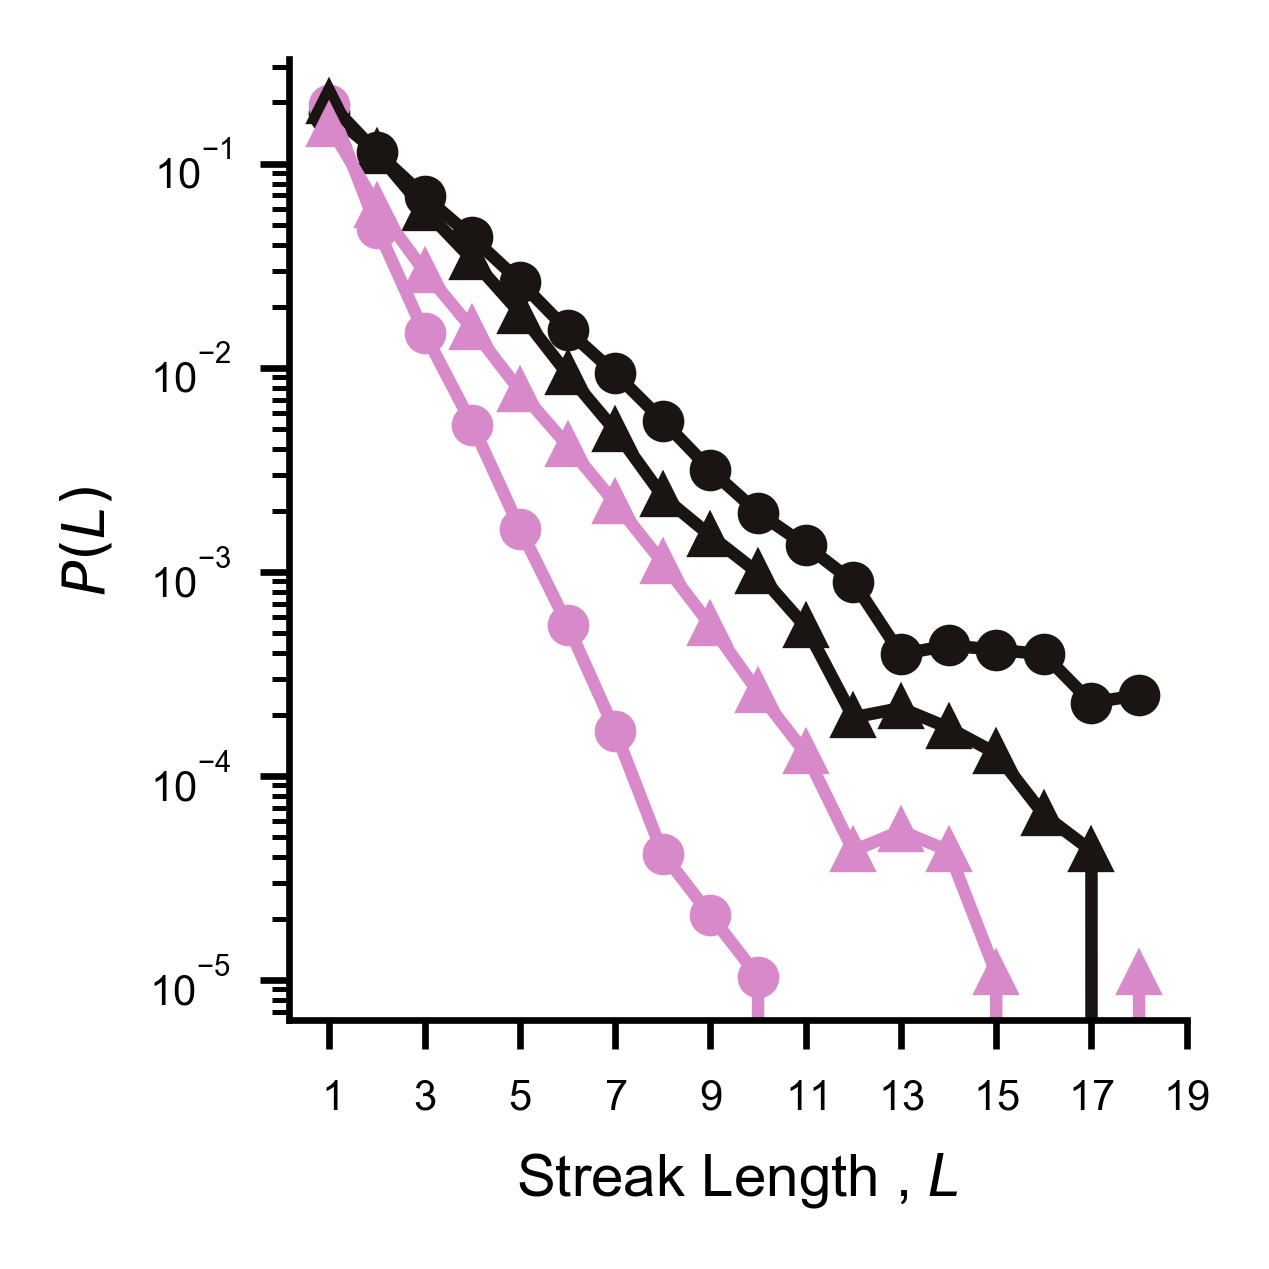

In [22]:
fig, ax = plt.subplots()

ax.plot(lenghts[:-1], streak_lengths_mc[0], "-o", color=FLR_colors[0], markersize=4)
ax.plot(lenghts[:-1], streak_lengths_mc[1:].mean(axis=0), "-o", color=FLR_colors[2], markersize=4)

ax.plot(lenghts[:-1], streak_lengths_hmm[0], "-^", color=FLR_colors[0], markersize=4)
ax.plot(lenghts[:-1], streak_lengths_hmm[1:].mean(axis=0), "-^", color=FLR_colors[2], markersize=4)

ax.set_yscale("log")
#ax.set_xlim(0,30)
ax.set_xticks(lenghts[::2])
ax.set_xlabel(r"Streak Length , $L$")
ax.set_ylabel(r"$P(L)$")

#sx, sy = 0.4, 0.3
#axins = ax.inset_axes([1-sx,1-sy,sx,sy])
#axins.plot(TEMPS, Decays[:,0,0], "-o", color=FLR_colors[0], zorder=0, markersize=2, linewidth=0.5)
#axins.plot(TEMPS, Decays[:,0,1], "-o", color=FLR_colors[2], zorder=2, markersize=2, linewidth=0.5)
#axins.plot(TEMPS, Decays[:,1,0], "-^", color=FLR_colors[0], zorder=1, markersize=2, linewidth=0.5)
#axins.plot(TEMPS, Decays[:,1,1], "-^", color=FLR_colors[2], zorder=3, markersize=2, linewidth=0.5)
#axins.set_xticks(TEMPS);
#axins.set_xlabel("Temperature (°C)")
#axins.set_ylabel(r"$L_0$")

fig.savefig("panels/Fig2/streaks.svg")

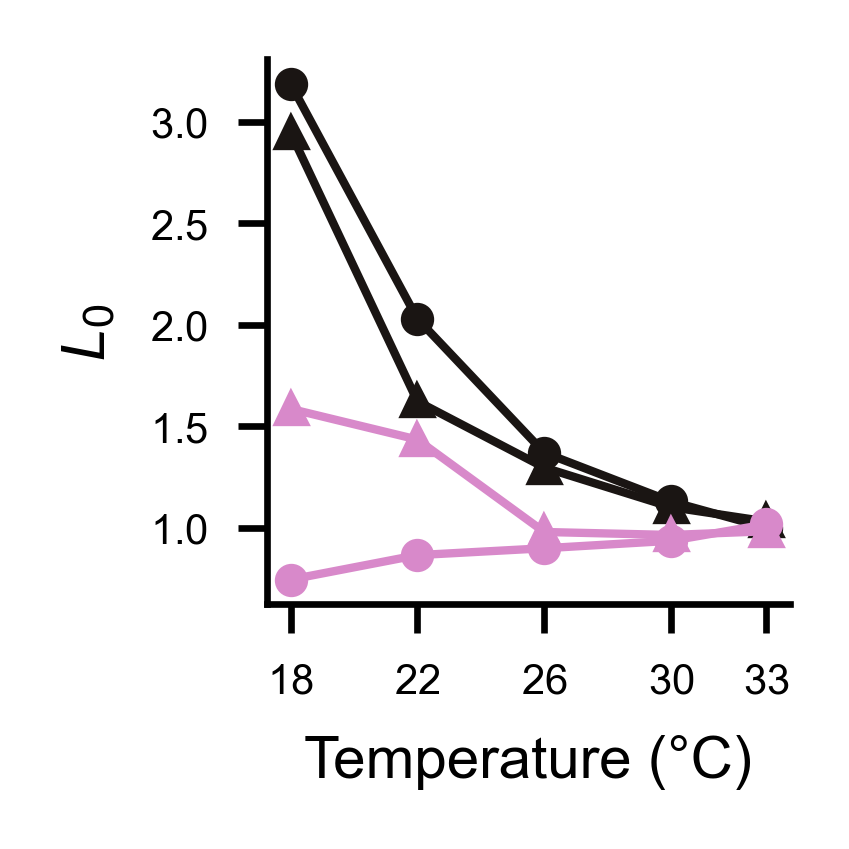

In [29]:
fig, ax = plt.subplots(figsize=(1.3,1.3))
ax.plot(TEMPS, Decays[:,0,0], "-o", color=FLR_colors[0], zorder=0, markersize=3, linewidth=1)
ax.plot(TEMPS, Decays[:,0,1], "-o", color=FLR_colors[2], zorder=2, markersize=3, linewidth=1)
ax.plot(TEMPS, Decays[:,1,0], "-^", color=FLR_colors[0], zorder=1, markersize=3, linewidth=1)
ax.plot(TEMPS, Decays[:,1,1], "-^", color=FLR_colors[2], zorder=3, markersize=3, linewidth=1)
ax.set_xticks(TEMPS);
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel(r"$L_0$")
fig.savefig("panels/Fig2/streaks_length.svg")

In [26]:
t = 1
temp = TEMPS[t]
Decays[t]
print(f"MC : turn={Decays[t,0,1]:0.2f}, forwards={Decays[t,0,0]:0.2f}")
print(f"HMM : turn={Decays[t,1,1]:0.2f}, forwards={Decays[t,1,0]:0.2f}")

MC : turn=0.87, forwards=2.03
HMM : turn=1.43, forwards=1.62


# Supplementaries

## confusion matrices

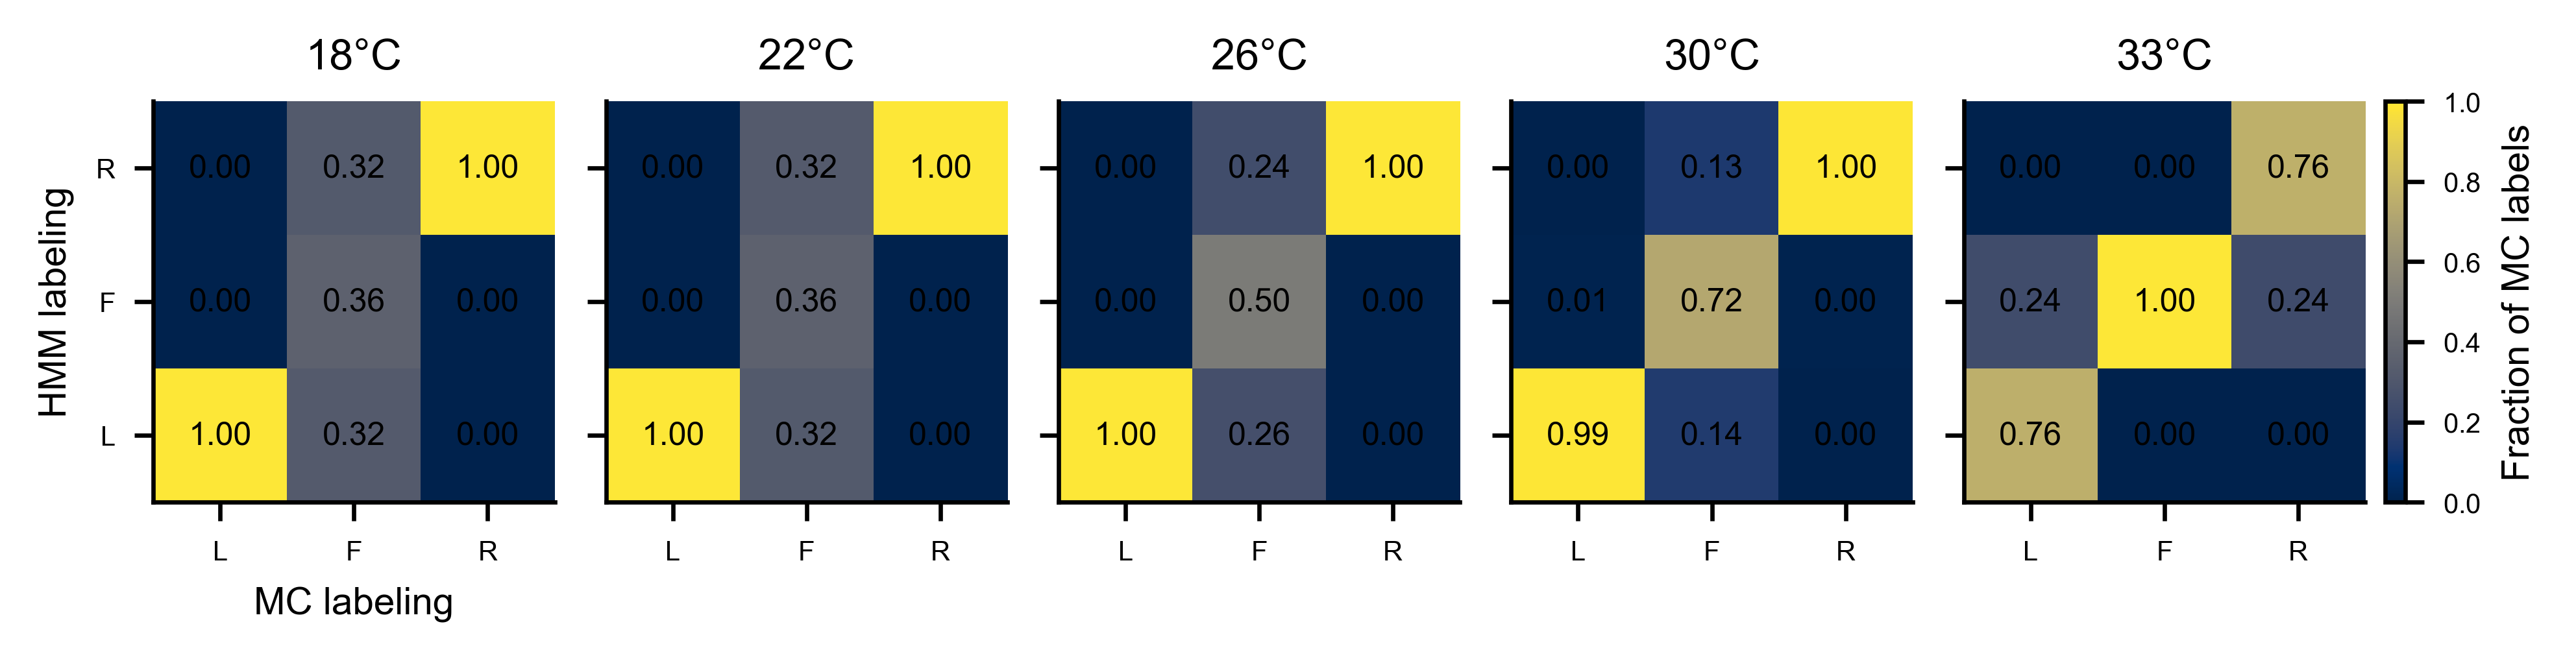

In [10]:
fig, axs = plt.subplots(ncols = len(TEMPS), figsize=(len(TEMPS)*1.3, 1.3 + 0.5), sharex=True, sharey=True)

for ax, temp in zip(axs,TEMPS):
    C = confusion(
        MC.threshold_classifier(load_sequences(DATAPATH, temp), -DTHETA_THRESH, +DTHETA_THRESH), 
        load_viterbi(MODELPATH, "g3", temp),
        3,
        3
    )
    h = plot_confusion(ax, 
        C[[1,0,2],:][:,[1,0,2]],
        ["L","F","R"],
        ["L","F","R"],
    )
    ax.set_title(f"{temp}°C")

fig.colorbar(h, ax=ax, label="Fraction of MC labels", shrink=0.60)
axs[0].set_xlabel("MC labeling")
axs[0].set_ylabel("HMM labeling")

fig.savefig("panels/Fig2/supps/confusion.svg")

## QQ plots - Mixture Model

In [ ]:
extract_models('../Models/mixtures.tar.gz')
qqfile = h5py.File("../Models/mixtures.h5")

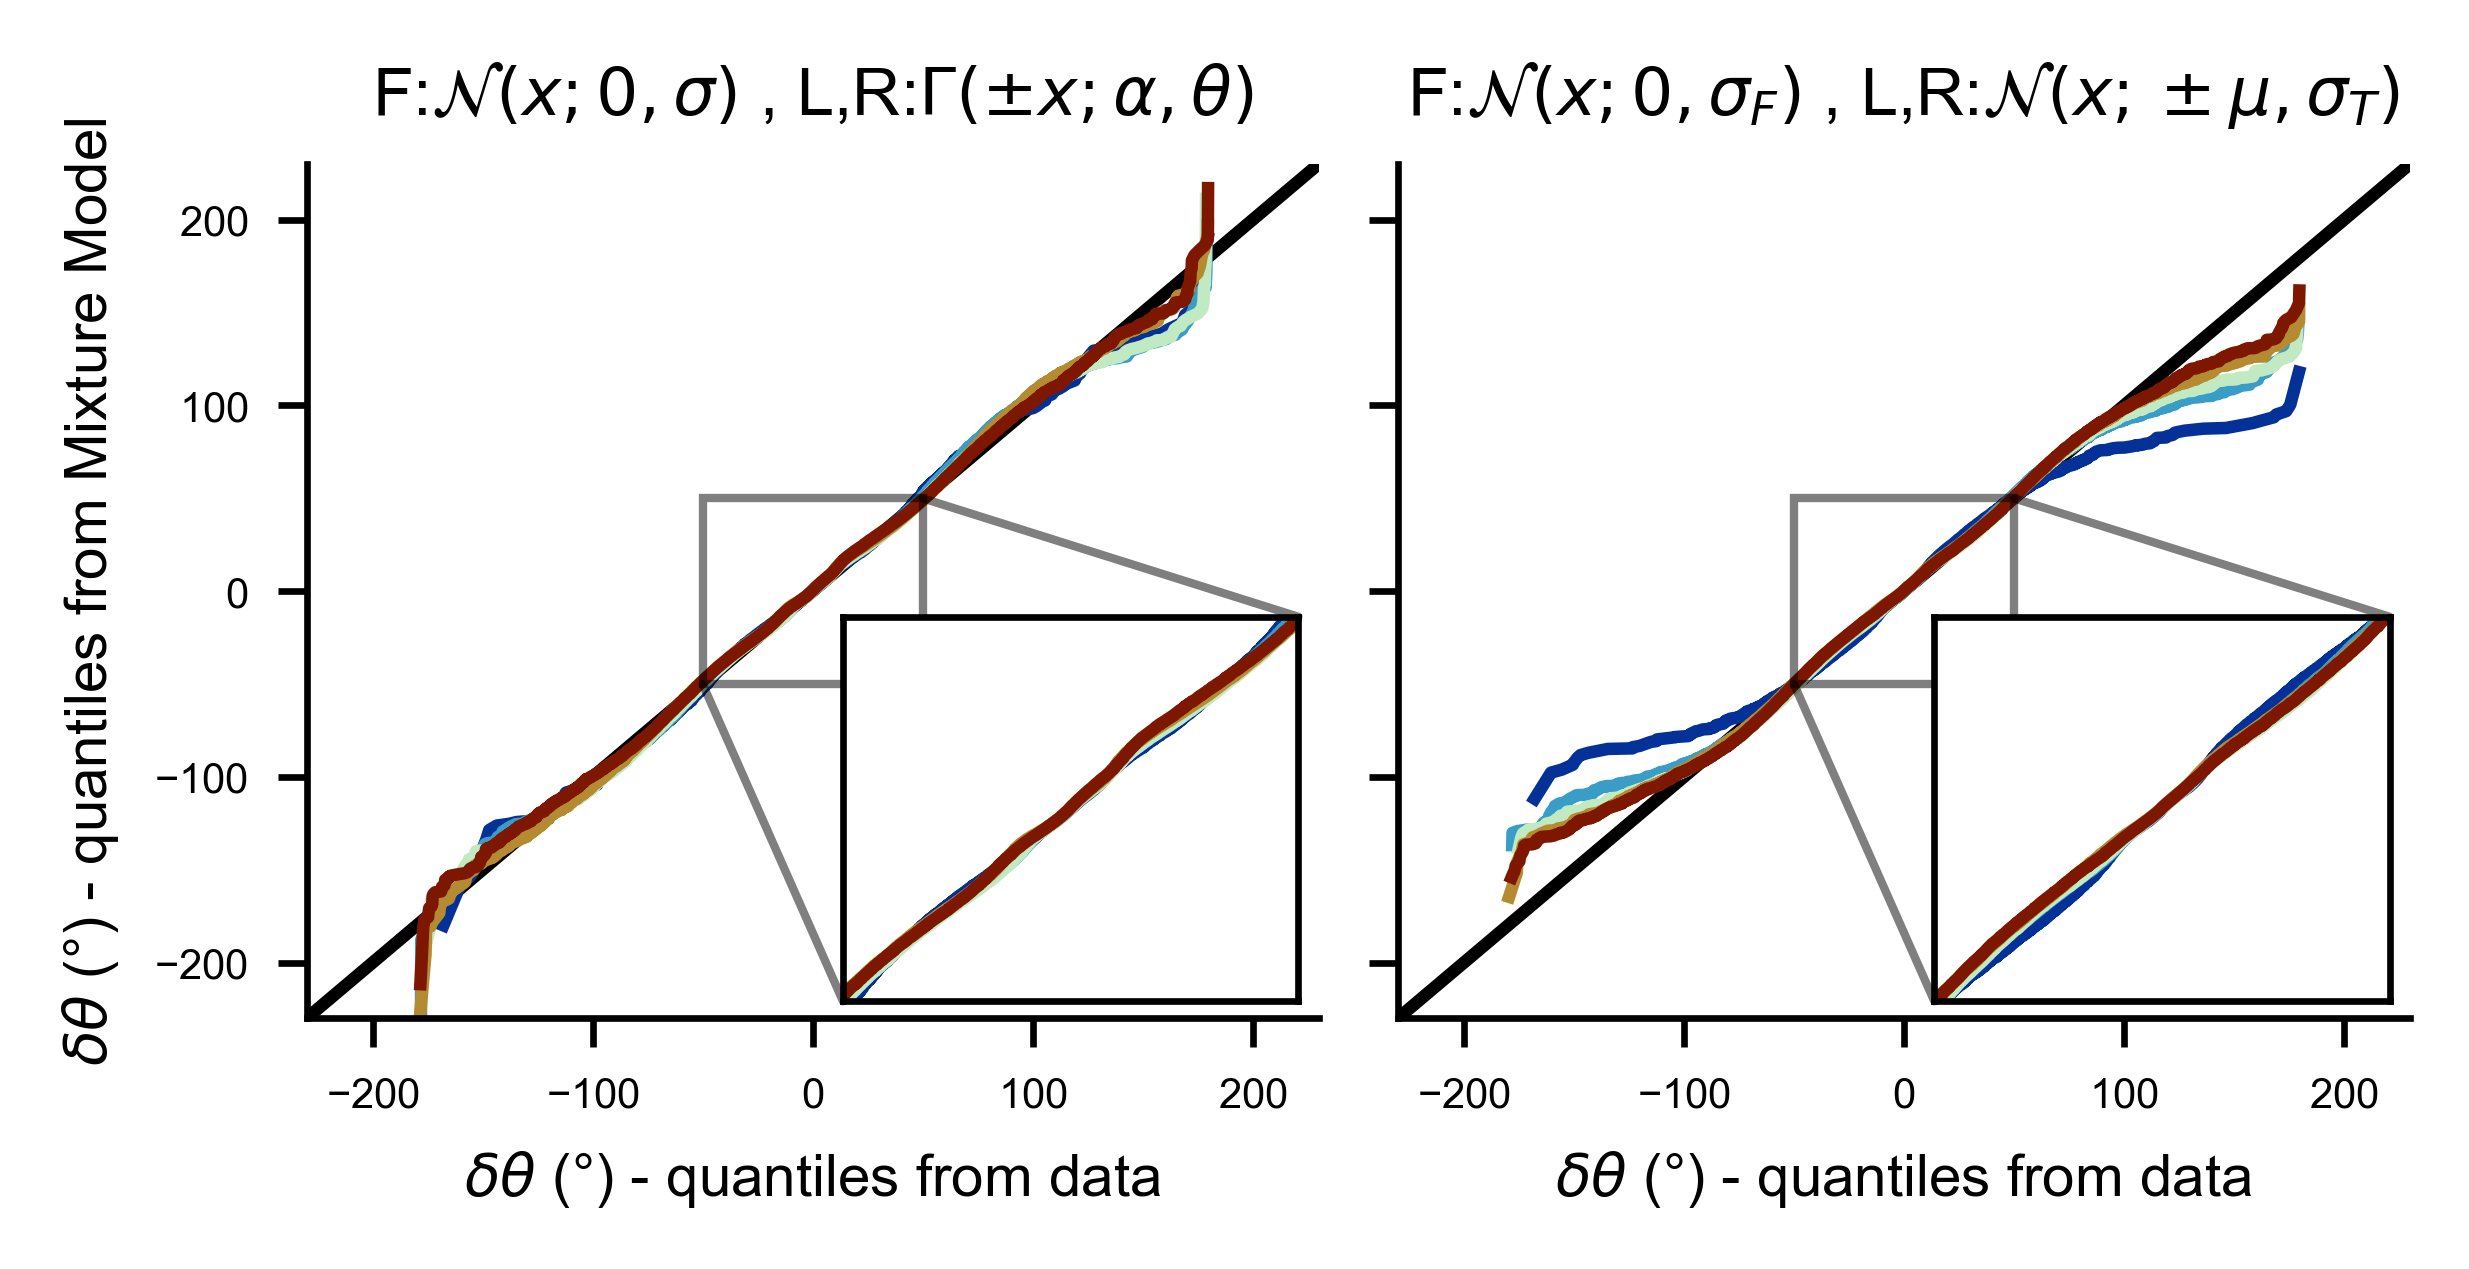

In [7]:
mmin, mmax = -230, +230
immin, immax = -50, +50
insize, inpad = 0.45, 0.02

fig, axs = plt.subplots(ncols=2, figsize=(2*2,2), sharex=True, sharey=True)

axs[0].set_title(r"F:$\mathcal{N}(x;0,\sigma)$ , L,R:$\Gamma(\pm x;\alpha,\theta)$")
axs[1].set_title(r"F:$\mathcal{N}(x;0,\sigma_F)$ , L,R:$\mathcal{N}(x;\pm\mu,\sigma_T)$")

axins = []
for ax in axs:
    ax.set_xlim(mmin, mmax)
    ax.set_ylim(mmin, mmax)
    ax.set_xlabel(r"$\delta \theta$ (°) - quantiles from data")
    ax.plot([mmin, mmax], [mmin, mmax], color="k" ,linestyle="-", zorder=0)
    axin = ax.inset_axes(
        [1-inpad-insize,inpad, insize, insize],
        xlim=(immin, immax),
        ylim=(immin, immax),
        xticklabels=[], yticklabels=[],
    )
    axin.spines[['right', 'top']].set_visible(True)
    axin.tick_params(left=False, bottom=False)
    ax.indicate_inset_zoom(axin, edgecolor="black")
    axins.append(axin)
    
axs[0].set_ylabel(r"$\delta \theta$ (°) - quantiles from Mixture Model")
    
for temp in TEMPS:
    for ax, axin, dset in zip(axs, axins, ["Gamma-Normal-Gamma","Normal-Normal-Normal"]):#, "TruncNormal-Normal-TruncNormal"]):
        QQx = qqfile[f"{temp}/{dset}/QQx"][:]
        QQy = qqfile[f"{temp}/{dset}/QQy"][:]
        ax.plot(QQx, QQy, color=TEMPS_COLS[temp])
        axin.plot(QQx, QQy, color=TEMPS_COLS[temp])

fig.savefig("panels/Fig2/supps/qqplots_mixtures.svg")

## Reproduction of reorientation distributions

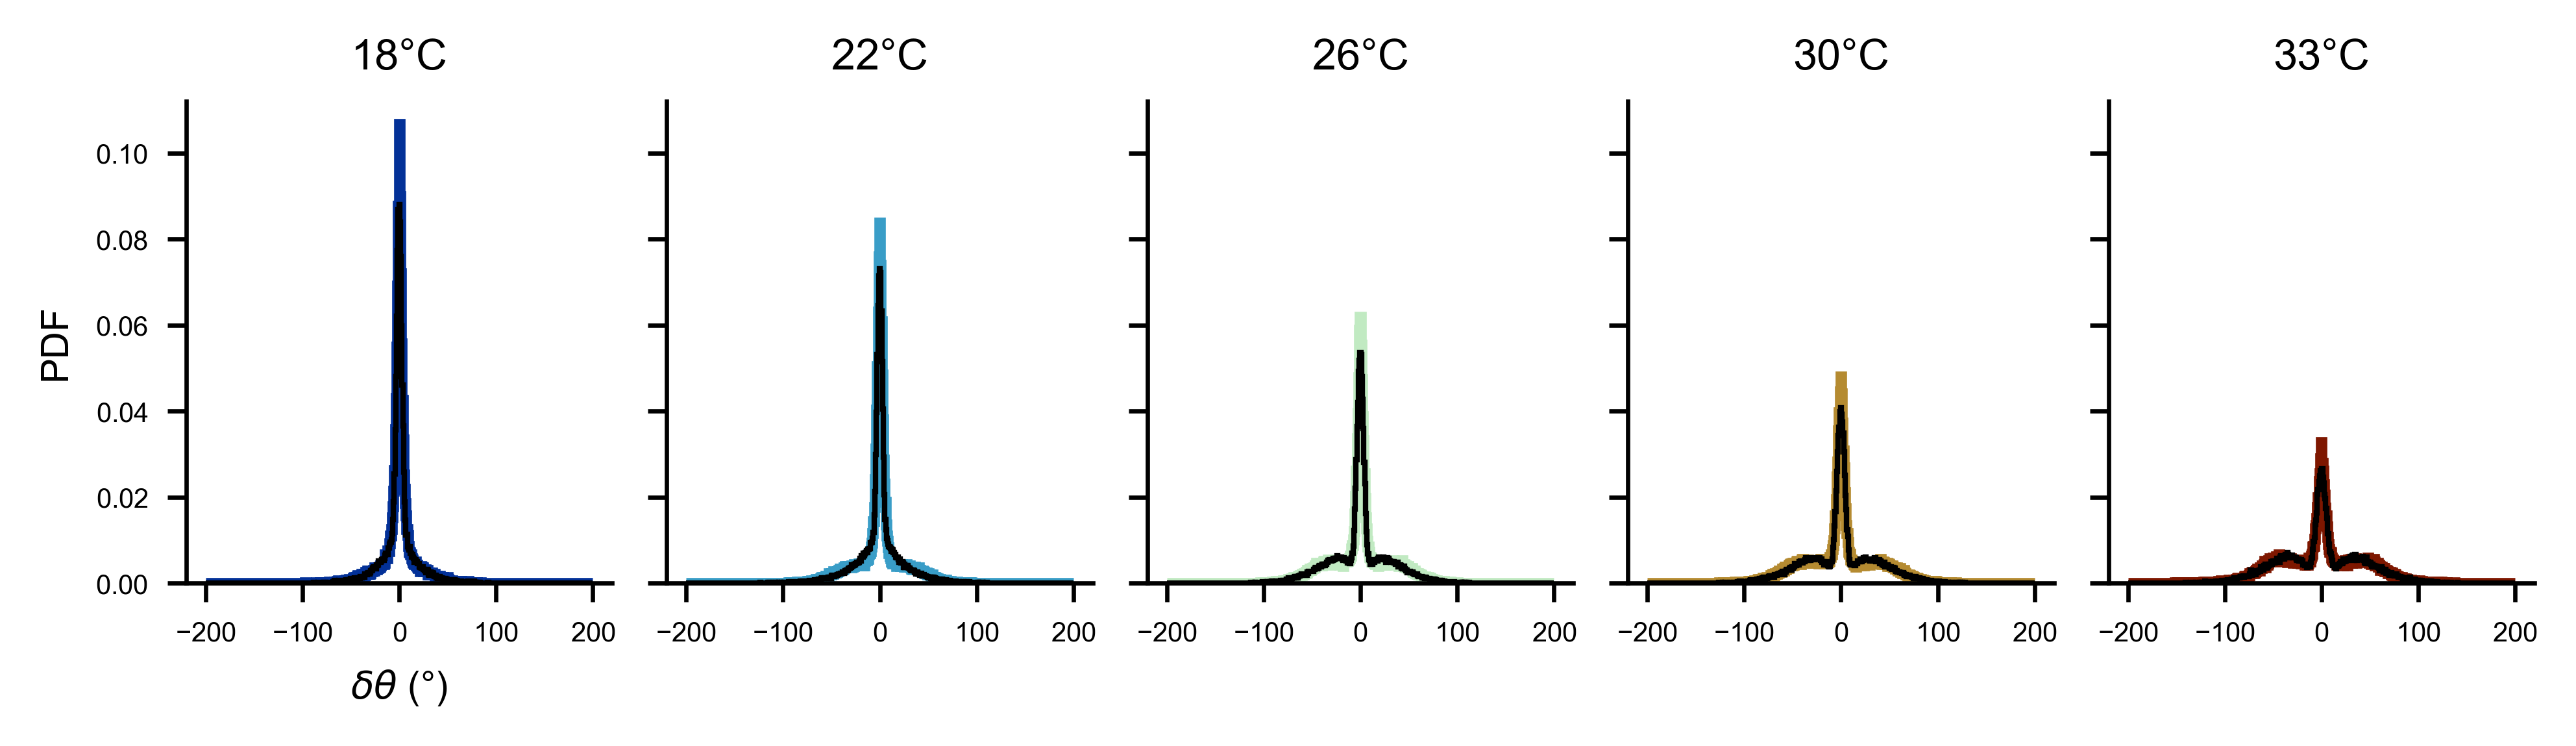

In [5]:
fig, axs = plt.subplots(ncols = len(TEMPS), figsize=(len(TEMPS)*1.3, 1.3 + 0.5), sharex=True, sharey=True)

bins = np.linspace(-200, +200, 500)

axs[0].set_xlabel(r"$\delta \theta$ (°)")
axs[0].set_ylabel("PDF")

for t,temp in enumerate(TEMPS):
    X_data = np.concatenate(load_sequences(DATAPATH, temp))
    X_gen = np.concatenate(load_genbouts(MODELPATH, "g3", temp))

    hdata,_ = np.histogram(X_data, bins)
    hdata = hdata/hdata.sum()
    hgen,_ = np.histogram(X_gen, bins)
    hgen = hgen/hgen.sum()
    
    axs[t].hist(X_data, bins=bins, histtype="step", density=True, color=TEMPS_COLS[temp], linewidth=2);
    axs[t].hist(X_gen, bins=bins, histtype="step", density=True, color="k");
    #axs[t].set_title(r"$JSD(data||generated) = "+f"{jsd:0.3f}"+r"$")
    axs[t].set_title(f"{temp}°C")
    #axs[t].set_yscale("log")

fig.savefig("panels/Fig2/supps/hists_data_vs_g3.svg")

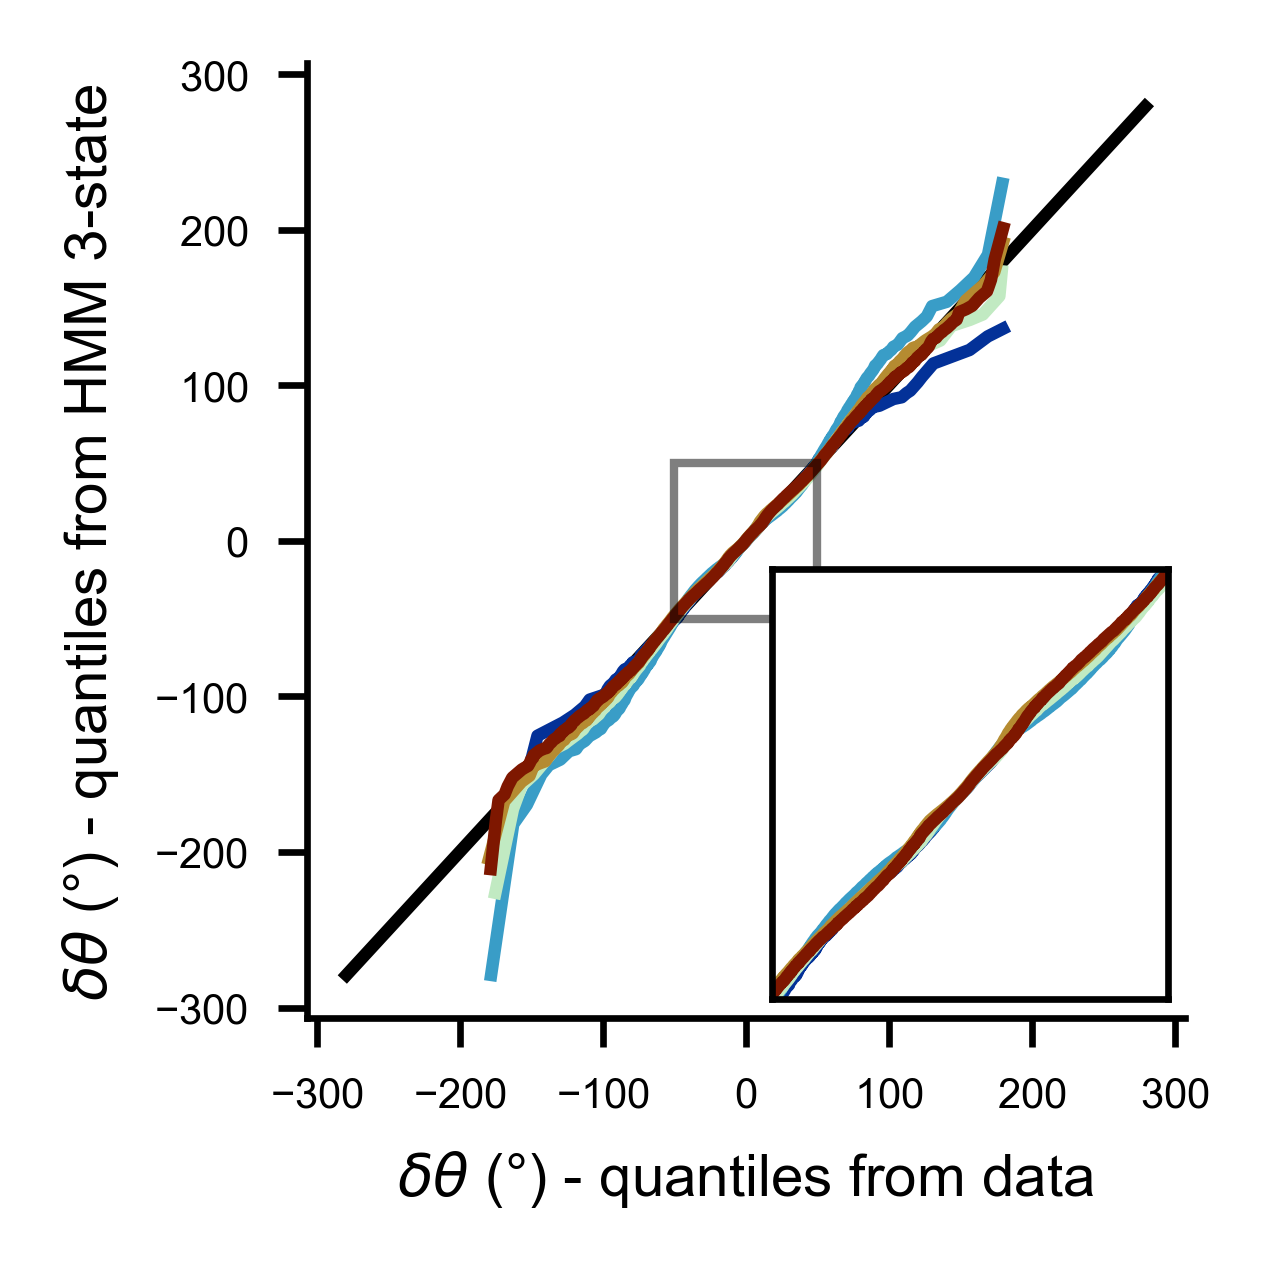

In [7]:
qs = np.linspace(0,1,10000)
immin, immax = -50, +50
insize, inpad = 0.45, 0.02

fig, ax = plt.subplots()

axin = ax.inset_axes(
    [1-inpad-insize,inpad, insize, insize],
    xlim=(immin, immax),
    ylim=(immin, immax),
    xticklabels=[], yticklabels=[],
)
axin.spines[['right', 'top']].set_visible(True)
axin.tick_params(left=False, bottom=False)
ax.indicate_inset_zoom(axin, edgecolor="black")
ax.set_xlabel(r"$\delta \theta$ (°) - quantiles from data")
ax.set_ylabel(r"$\delta \theta$ (°) - quantiles from HMM 3-state")

amax = 0
for t, temp in enumerate(TEMPS):
    X_data = np.concatenate(load_sequences(DATAPATH, temp))
    X_gen = np.concatenate(load_genbouts(MODELPATH, "g3", temp))

    Q_data = np.quantile(X_data, qs)
    Q_gen = np.quantile(X_gen, qs)
    amax = max(amax, np.abs(Q_data).max())
    amax = max(amax, np.abs(Q_gen).max())
    ax.plot(Q_data, Q_gen, color=TEMPS_COLS[temp], zorder=1)
    axin.plot(Q_data, Q_gen, color=TEMPS_COLS[temp], zorder=1)

ax.plot([-amax, amax], [-amax, amax], zorder=0)

fig.savefig("panels/Fig2/supps/qqplots_data_vs_g3.svg")

## Model Likelyhoods

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
def split_train_test(seqs, epochs=100, f=0.75):
    n = len(seqs)
    nt = int(n*f)
    inds = np.arange(n)
    TRAIN = np.empty((epochs, nt), dtype=np.int_)
    TEST = np.empty((epochs, n-nt), dtype=np.int_)
    for e in range(epochs):
        np.random.shuffle(inds)
        TRAIN[e] = inds[:nt]
        TEST[e] = inds[nt:]
    return TRAIN, TEST

def LL_single_sequence(seq, T):
    pb = MC.steady_state(T)
    p1 = pb[seq[0]]
    i = np.arange(len(seq)-1)
    ps = T[seq[i], [seq[i+1]]]
    return np.log(ps).sum() + np.log(p1)
    
def LL_sequences(seqs, T):
    Ps = []
    for seq in seqs:
        Ps.append(LL_single_sequence(seq, T))
    return np.array(Ps)

def LL_temp(temp, thresh=10):
    X = load_sequences(DATAPATH, temp)
    bouts = MC.threshold_classifier(X, -thresh, +thresh)
    train_inds, test_inds = split_train_test(bouts)
    LLHs = np.empty_like(test_inds, dtype=np.float_)
    for e in range(train_inds.shape[0]):
        train = [bouts[i] for i in train_inds[e]]
        test = [bouts[i] for i in test_inds[e]]
        T = MC.bout_transitions(train, n_state=3)
        LLHs[e] = LL_sequences(test, T)
    return LLHs

In [5]:
LLHs = []
Temps = []
MODELS = []
for temp in TEMPS:
    llhs_hmm = load_LLHs(MODELPATH, "g3", temp)
    llhs_mc = LL_temp(temp)
    llhs_mc = llhs_mc.ravel()
    
    LLHs.append(llhs_hmm)
    Temps.append(np.full_like(llhs_hmm, temp, dtype=np.int_))
    MODELS.append(np.full_like(llhs_hmm, "hmm", dtype="<U4"))
    LLHs.append(llhs_mc)
    Temps.append(np.full_like(llhs_mc, temp, dtype=np.int_))
    MODELS.append(np.full_like(llhs_mc, "mc", dtype="<U4"))

df = pd.DataFrame.from_dict({
    "LLHs" : np.concatenate(LLHs),
    "Temps" : np.concatenate(Temps),
    "MODELS" : np.concatenate(MODELS),
})
df

,LLHs,Temps,MODELS
0,-1182.187301,18,hmm
1,-70.086385,18,hmm
2,-165.991805,18,hmm
3,-93.044743,18,hmm
4,-166.953971,18,hmm
...,...,...,...
430795,-49.352499,33,mc
430796,-94.506062,33,mc
430797,-117.629395,33,mc
430798,-69.659281,33,mc


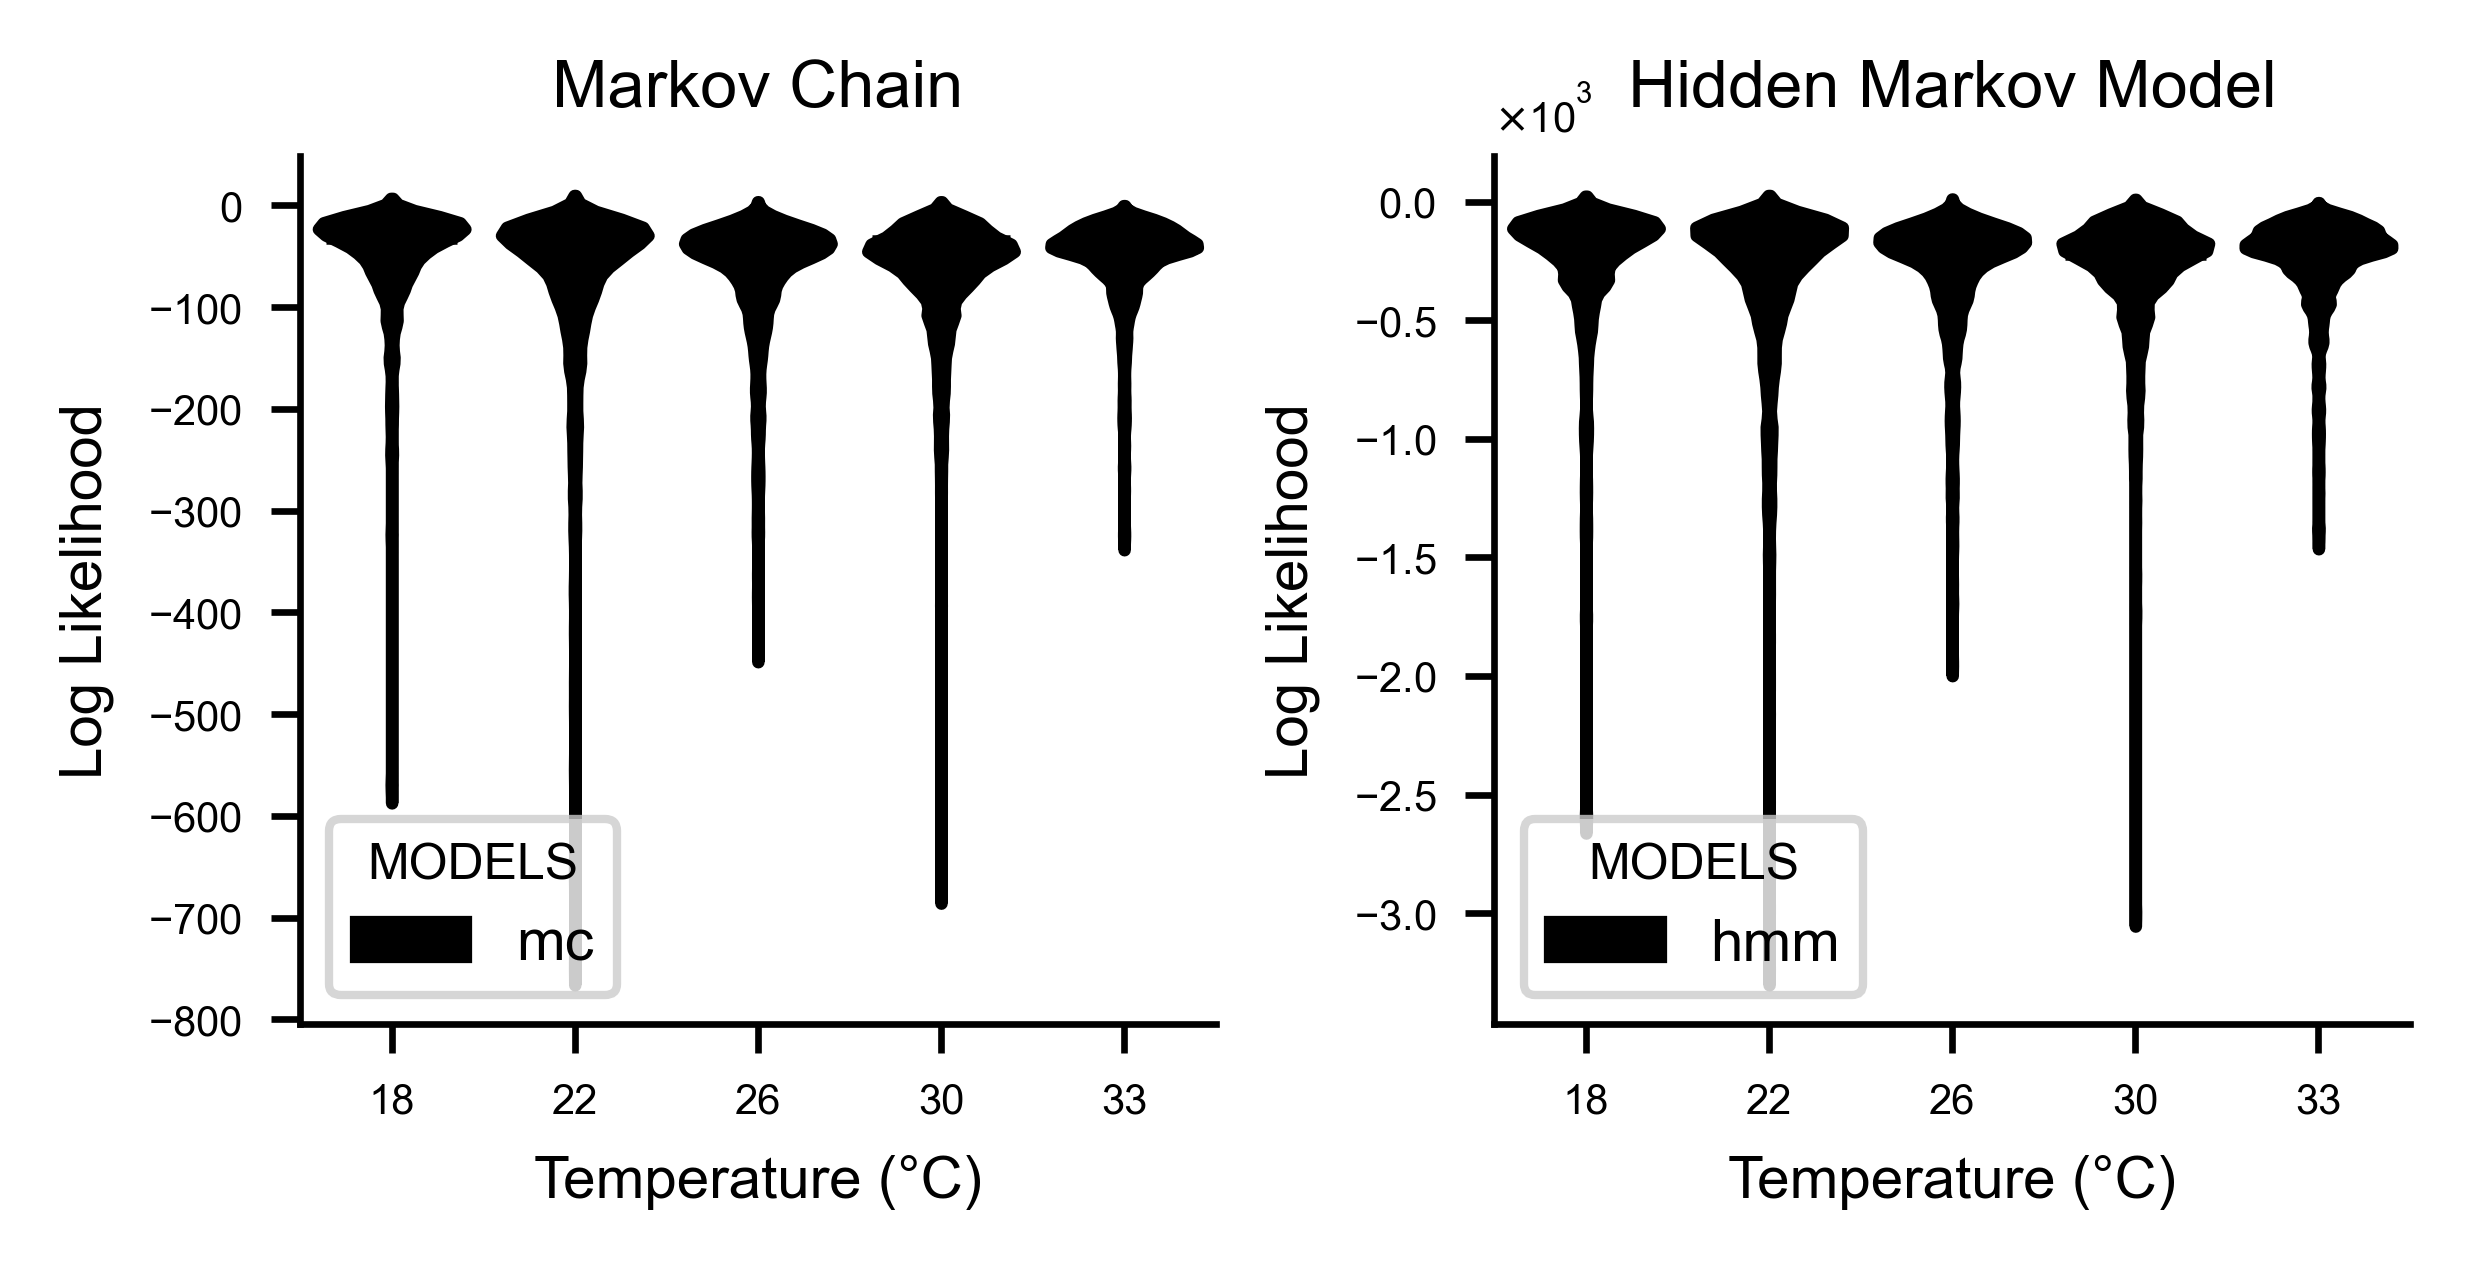

In [8]:
fig, axs = plt.subplots(ncols = 2, figsize=(2*2,2))

ax = axs[0]
ax.set_title("Markov Chain")
sns.violinplot(
        ax=ax,
        data=df[df["MODELS"]=="mc"], x="Temps", y="LLHs", hue="MODELS", 
        split=False, 
        inner="quart",
        density_norm="width",
        legend=False,
        #cut=0,
    )
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Log Likelihood")

ax = axs[1]
ax.set_title("Hidden Markov Model")
sns.violinplot(
        ax=ax,
        data=df[df["MODELS"]=="hmm"], x="Temps", y="LLHs", hue="MODELS", 
        split=False, 
        inner="quart",
        density_norm="width",
        legend=False,
        #cut=0,
    )
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Log Likelihood")

fig.savefig(f"panels/Fig2/supps/LLHs.svg")